# STRING - Classic preprocessing

Este notebook es una primera aproximación donde se preprocesarán las interacciones físicas directas registradas en el dataset STRING y se codificarán numéricamente para en el siguiente notebook hacer el entrenamiento del modelo.

Para ello, se ha descargado el dataset con interacciones físicas filtrado por la especie homo sapiens.

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

## 1. Exploración de datos

In [ ]:
import pandas as pd

db_string_path = '../datasets/9606.protein.physical.links.full.v12.0.txt'
df_string = pd.read_csv(db_string_path, sep=' ', low_memory=False)

df_string.head()

,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000257770,0,312,0,0,0,0,0,311
1,9606.ENSP00000000233,9606.ENSP00000226004,0,162,0,0,0,0,0,161
2,9606.ENSP00000000233,9606.ENSP00000434442,0,0,0,500,0,0,0,499
3,9606.ENSP00000000233,9606.ENSP00000262455,0,531,0,0,0,0,0,531
4,9606.ENSP00000000233,9606.ENSP00000303145,0,0,0,500,0,0,0,499


In [2]:
df_string.shape

(1477610, 10)

In [3]:
df_string.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477610 entries, 0 to 1477609
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   protein1                 1477610 non-null  object
 1   protein2                 1477610 non-null  object
 2   homology                 1477610 non-null  int64 
 3   experiments              1477610 non-null  int64 
 4   experiments_transferred  1477610 non-null  int64 
 5   database                 1477610 non-null  int64 
 6   database_transferred     1477610 non-null  int64 
 7   textmining               1477610 non-null  int64 
 8   textmining_transferred   1477610 non-null  int64 
 9   combined_score           1477610 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 112.7+ MB


In [4]:
df_string.isna().sum().sum()

np.int64(0)

## 2. Limpieza y preparación de datos
El dataset de STRING que hemos descargado indica en la propia web: "incl. distinction: direct vs. interologs". Esto significa que se indica qué interacciones son directas o por interología. Para nuestro proyecto buscamos aquellas directas comprobadas en humanos mediante técnicas experimentales. Estas son las que tienen experimentos registrados.

In [5]:
df_direct = df_string[df_string['experiments'] > 0]
print(f"Total de interacciones con evidencia experimental directa: {len(df_direct)}")
df_direct.head()

Total de interacciones con evidencia experimental directa: 947158


,protein1,protein2,homology,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000257770,0,312,0,0,0,0,0,311
1,9606.ENSP00000000233,9606.ENSP00000226004,0,162,0,0,0,0,0,161
3,9606.ENSP00000000233,9606.ENSP00000262455,0,531,0,0,0,0,0,531
5,9606.ENSP00000000233,9606.ENSP00000263265,0,292,0,0,0,0,0,292
6,9606.ENSP00000000233,9606.ENSP00000365686,0,221,0,0,0,0,0,221


Ahora que tenemos aquellas proteínas con interacción física directa, obtenemos el listado de proteínas únicas y nos quedamos con los pares de proteínas conocidos (estos serán nuestros casos positivos) para luego generar pares que no estén registrados (estos serán los casos negativos).

In [6]:
# Obtenemos todas las proteínas únicas
all_proteins = pd.unique(df_string[['protein1', 'protein2']].values.ravel())
print(f"Número de proteínas únicas: {len(all_proteins)}")

Número de proteínas únicas: 18767


In [7]:
positive_pairs = set(
    tuple(sorted([row['protein1'], row['protein2']]))
    for _, row in df_direct.iterrows()
)

In [8]:
import random

negative_pairs = set()

while len(negative_pairs) < len(df_direct):
    p1, p2 = random.sample(list(all_proteins), 2)
    pair = tuple(sorted([p1, p2]))
    if pair not in positive_pairs:
        negative_pairs.add(pair)

Acabamos de generar el set de casos negativos para nuestro modelo. Sin embargo, hay que aclarar que aquí nos encontramos ante uno de los mayores desafíos conceptuales de las PPI: los casos negativos no implica que esas dos proteínas se haya demostrado que no interactúen entre ellas, implica que su interacción no está recogida dentro del listado de interacciones conocidas. Esto nos dice que un par del set de negativos podría en realidad dar lugar a una interacción positiva si se hiciese una prueba experimental. Entonces, **asumimos que los pares "negativos" no es que no interactúen entre ellas, sino que desconocemos su interacción**.

In [9]:
df_negative = pd.DataFrame(list(negative_pairs), columns=['protein1', 'protein2'])
df_negative['label'] = 0

df_positive = df_direct[['protein1', 'protein2']].copy()
df_positive['label'] = 1

df_string_balanced = pd.concat([df_positive, df_negative], ignore_index=True)

In [ ]:
import importlib
import src.fasta_parser
importlib.reload(src.fasta_parser)

from fasta_parser import FastaParser

fasta_parser = FastaParser("../datasets/Homo_sapiens.GRCh38.pep.all.fa")
protein_seqs = fasta_parser.to_dict()

print(f"Total de proteínas indexadas: {len(protein_seqs)}")

Total de proteínas indexadas: 123887


In [11]:
for i, (ensembl_id, seq) in enumerate(protein_seqs.items()):
    print(f"{ensembl_id}: {seq[:50]}...")
    if i >= 4:
        break

ENSP00000451468: XSQPHTKPSVFVMKNGTNVACLVKEFYPKDIRINLVSSKKITEFDPAIVI...
ENSP00000480116: XIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKTVL...
ENSP00000487742: XDLNKVFPPEVAVFEPSEAEISHTQKATLVCLATGFFPDHVELSWWVNGK...
ENSP00000488819: XDLNKVFPPEVAVFEPSEAEISHTQKATLVCLATGFFPDHVELSWWVNGK...
ENSP00000478873: XDLKNVFPPEVAVFEPSEAEISHTQKATLVCLATGFYPDHVELSWWVNGK...


In [12]:
df_string_balanced["sequence1"] = df_string_balanced["protein1"].apply(
    lambda p: protein_seqs.get(fasta_parser.extract_ensembl_id(p), None)
)
df_string_balanced["sequence2"] = df_string_balanced["protein2"].apply(
    lambda p: protein_seqs.get(fasta_parser.extract_ensembl_id(p), None)
)

In [13]:
df_string_balanced.shape

(1894316, 5)

In [14]:
df_string_balanced.isna().sum().sum()

np.int64(66790)

Observamos que hay 66626 NaNs en nuestro DF tras añadir las secuencias de aminoácidos. Investigamos qué ocurre.

In [ ]:
from utils import analyze_missing_proteins

analyze_missing_proteins(df_string_balanced, protein_seqs)

🔍 Pares con al menos un ID faltante: 66148
🔍 IDs únicos no encontrados: 366

🔍 Ejemplos de IDs no encontrados:
['ENSP00000500939', 'ENSP00000479207', 'ENSP00000495398', 'ENSP00000482678', 'ENSP00000357126', 'ENSP00000480313', 'ENSP00000359563', 'ENSP00000468007', 'ENSP00000485582', 'ENSP00000482810']


Parece que el problema es que 366 proteínas del dataset de STRING no se encuentran en el archivo FASTA de Ensembl. Esto puede deberse a distintos factores, como que las proteínas hayan sido renombradas, retiradas o aún no incluídas en el fichero de Ensembl. Teniendo en cuenta que tenemos un dataset con 1.894.316 entradas, eliminar 66.626 no se considera un problema.

In [16]:
df_string_balanced.dropna(inplace=True)

## Sequence encoding

Antes de codificar y preparar las secuencias proteicas como entrada al modelo, tenemos que determinar una longitud máxima (`max_length`) para todas ellas. Los modelos de deep learning, especialmente aquellos que trabajan con batches, requieren entradas de tamaño fijo.

Para definir un `max_length` adecuado, analizaremos la distribución de longitudes de todas las secuencias de proteínas involucradas en los pares del dataset. Esto nos permitirá encontrar un equilibrio entre:

- Maximizar la cobertura (evitar truncar demasiadas secuencias)
- Minimizar el uso de memoria y el tiempo de entrenamiento

count    3.656336e+06
mean     6.112483e+02
std      6.530258e+02
min      2.500000e+01
25%      2.760000e+02
50%      4.570000e+02
75%      7.390000e+02
max      3.599100e+04
dtype: float64
Cuantiles:
0.50     457.0
0.75     739.0
0.90    1174.0
0.95    1622.0
0.99    2839.0
dtype: float64


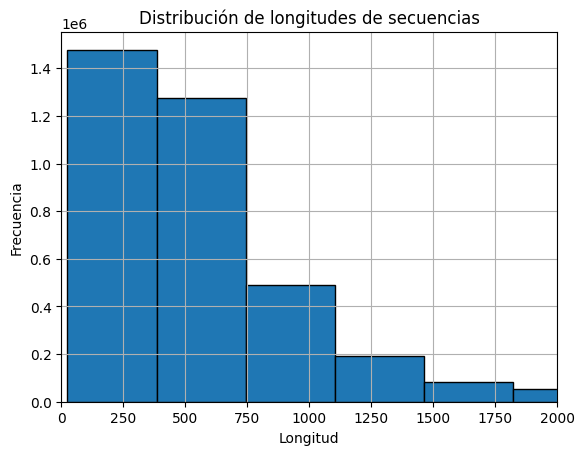

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df_string_balanced["len_seq1"] = df_string_balanced["sequence1"].str.len()
df_string_balanced["len_seq2"] = df_string_balanced["sequence2"].str.len()

lengths = pd.concat([df_string_balanced["len_seq1"], df_string_balanced["len_seq2"]])

print(lengths.describe())
print("Cuantiles:")
print(lengths.quantile([0.5, 0.75, 0.90, 0.95, 0.99]))

plt.hist(lengths, bins=100, edgecolor="black")
plt.title("Distribución de longitudes de secuencias")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

El histograma muestra que la gran mayoría de las secuencias tienen una longitud inferior a 1000 aminoácidos. En concreto, los percentiles calculados reflejan que:

- El 90 % de las secuencias tienen ≤ 1174 aminoácidos
- El 95 % tienen ≤ 1621
- El 99 % tienen ≤ 2817

Basándonos en esta distribución, se ha decidido establecer un `max_length` de **1024**. Este valor permite cubrir hasta casi el 90 % de las secuencias sin truncamiento, al tiempo que mantiene un consumo de memoria razonable compatible con la GPU disponible. Las secuencias más largas serán truncadas para ajustarse a esta longitud, mientras que las más cortas serán completadas mediante padding.

In [ ]:
# Borramos todos los DFs excepto el df_string_balanced
import gc

del df_string
del df_direct
del df_negative
del df_positive
gc.collect()

# Guardamos el DataFrame balanceado
df_string_balanced.drop(columns=["len_seq1", "len_seq1"], inplace=True)
df_string_balanced.to_parquet("../datasets/df_string_balanced.parquet")

print(f"Memoria liberada. Tamaño final del dataset: {len(df_string_balanced)} filas")

Memoria liberada. Tamaño final del dataset: 1828168 filas


In [ ]:
# import sys
# import os
# sys.path.append(os.path.abspath("../src"))

# import pandas as pd
# df_string_balanced = pd.read_parquet("../datasets/df_string_balanced.parquet")
# df_string_balanced.drop(columns=["len_seq1", "len_seq1"], inplace=True)

In [ ]:
from encoders.numeric_sequence_encoder import NumericSequenceEncoder
from sequence_preprocessor import SequencePreprocessor

encoder = NumericSequenceEncoder()
preprocessor = SequencePreprocessor(encoder, max_length=1024, chunk_size=20000)

df_encoded = preprocessor.process_dataframe(df_string_balanced)
df_encoded.to_parquet("../processed_data/classic_encoded_1024.parquet")

### Conclusión del preprocesamiento

En este primer notebook se ha llevado a cabo el preprocesamiento completo del dataset de interacciones proteína-proteína (PPI) con evidencia experimental directa, extraído de la base de datos STRING.

El proceso incluyó la asociación de secuencias de aminoácidos mediante identificadores Ensembl, la codificación numérica de las secuencias con una longitud máxima de 1024 residuos, y el etiquetado binario de las interacciones (positivas y negativas). Para ello se implementaron clases reutilizables siguiendo principios de diseño limpio y modular, como `SequencePreprocessor` y `SequenceEncoder`.

El resultado final es un archivo en formato `.parquet` que contiene los datos preprocesados y balanceados, listos para ser utilizados en la fase de entrenamiento del modelo de deep learning. Este enfoque desacopla el procesamiento de datos del entrenamiento, facilitando futuras pruebas con distintos modelos y codificadores sin necesidad de repetir esta etapa.
